# XAITK-Armory Adversarial Robustness Example <a name="XAITK-Saliency-Armory-Example"></a>
This notebook makes use of the benign (background green screen patch) and adversarial (background noise patch) scenario images generated from the TwoSix team's armory scenario generation [notebook](https://colab.research.google.com/gist/christopherwoodall/8c25aebd5858304046d5ff9a93d5b95d/running_armory_scenarios_interactively.ipynb), and explores generating saliency maps on the patches using ``xaitk-saliency``.

In [ ]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q torch
!{sys.executable} -m pip install -q torchvision

## Test Images <a name="Test-Images-XAITK-Armory"></a>

Visualization of the armory scenarios with the benign and adversarial patches embedded onto a background building.

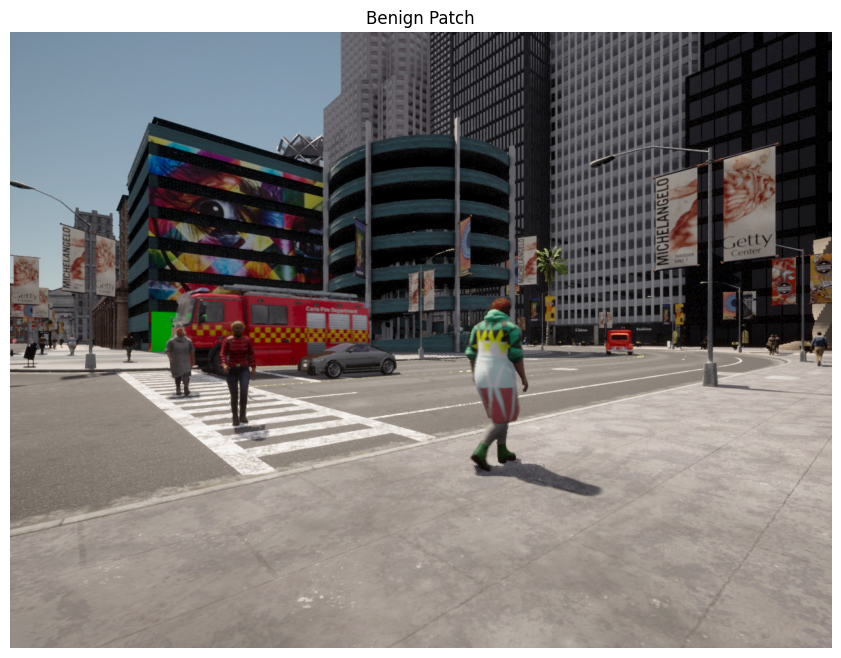

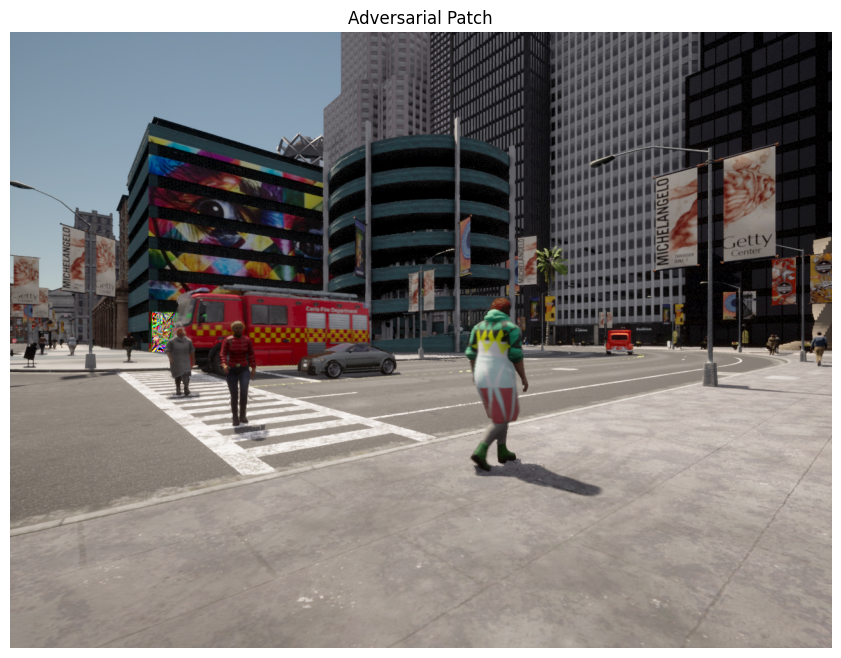

In [1]:
import os
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "png"

os.makedirs('data/adversarial-patches', exist_ok=True)
test_benign_image_filename = 'data/adversarial-patches/benign_batch_1.png'
plt.figure(figsize=(12, 8))
plt.title("Benign Patch")
plt.axis('off')
target_benign = PIL.Image.open(test_benign_image_filename)
_ = plt.imshow(target_benign)
test_adversarial_image_filename = './data/adversarial-patches/adversarial_batch_1.png'
plt.figure(figsize=(12, 8))
plt.title("Adversarial Patch")
plt.axis('off')
target_adversarial = PIL.Image.open(test_adversarial_image_filename)
_ = plt.imshow(target_adversarial)

## Load Custom SMQTK wrapped Armory FRCNN model <a name="Load-Model-XAITK-Armory"></a>

The cell below loads in the FRCNN-Resnet50 weights from the ``armory`` pretrained model using a custom version of the SMQTK ResNetFRCNN wrapper (``armory_smqtk_detect_objects.py``)

In [2]:
from armory_smqtk_detect_objects import ResNetFRCNN # type: ignore

detector = ResNetFRCNN(
    box_thresh=0.5,
    img_batch_size=1,
    use_cuda=True
)

## Generate and Visualize Model Detections <a name="Generate-Detections-XAITK-Armory"></a>
We visualize the detections from the ``armory`` model on the benign and adversarial image samples from the same scenario.

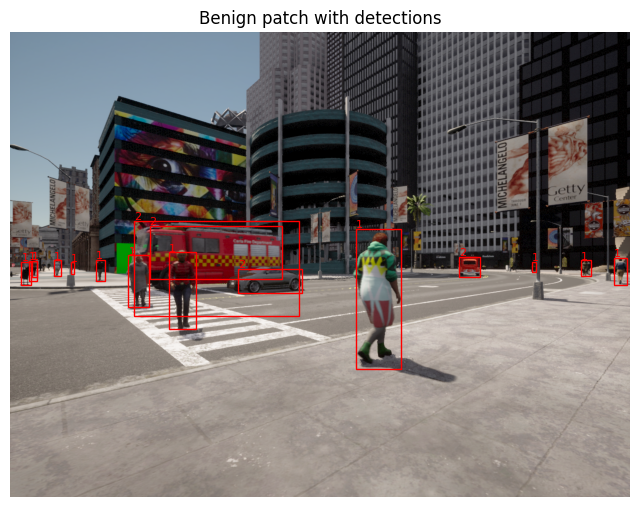

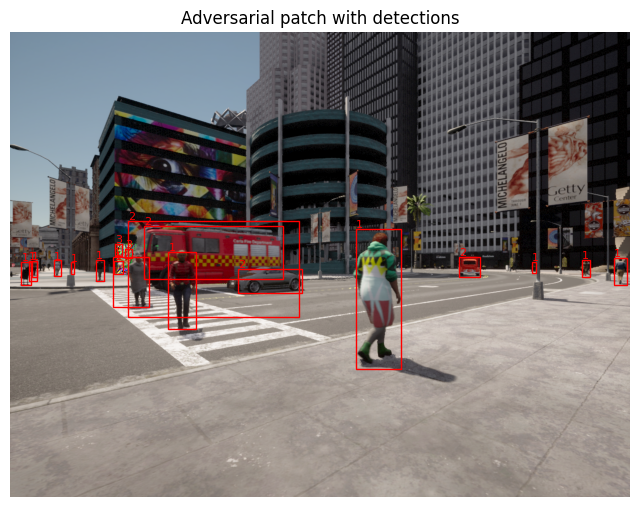

In [3]:
import numpy as np
from matplotlib.patches import Rectangle

class_ids = {'person': '1', 'vehicle': '2', 'traffic light':'3'}

def show_dets(ax, dets, thresh=0.5, show_labels=True):
    for i, det in enumerate(dets):
        score_dict = det[1]
        cls_name = max(score_dict, key=score_dict.get)
        conf = score_dict[cls_name]
        
        if conf >= thresh:
            bbox = det[0]
            x1, y1 = bbox.min_vertex
            x2, y2 = bbox.max_vertex
            ax.add_patch(Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            ))

            if show_labels:
                label=f'{class_ids[cls_name]}'
                ax.text(x1, y1 - 2, label, color='r', fontsize=8)

# Display detections
img_benign = np.asarray(target_benign)
dets = list(detector([img_benign]))[0]
fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Benign patch with detections")
axs.imshow(img_benign)
axs.axis("off")
show_dets(axs, dets, thresh=0.4)

img = np.asarray(target_adversarial)
dets = list(detector([img]))[0]
fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Adversarial patch with detections")
axs.imshow(img)
axs.axis("off")
show_dets(axs, dets, thresh=0.4)

## Prepare Inputs for Saliency Generation <a name="Prepare-Inputs-XAITK-Armory"></a>
The ``GenerateObjectDetectorBlackboxSaliency`` interface requires our reference detections to be split into separate bounding boxes and scores inputs.

In [4]:
def dets_to_mats(dets):
    
    labels = list(dets[0][1].keys())
    print(labels)
    bboxes = np.empty((0, 4))
    scores = np.empty((0, 3))

    for det in dets:
        bbox = det[0]
        
        bboxes = np.vstack((
            bboxes,
            [*bbox.min_vertex, *bbox.max_vertex]
        ))

        score_dict = det[1]
        
        score_array = []
        for l in labels:
            score_array.append(score_dict[l])
            
        scores = np.vstack((
            scores,
            score_array
        ))

    return bboxes, scores

## Generate and Visualize Saliency Maps <a name="Generate-Saliency-XAITK-Armory"></a>

Generate saliency maps for specific detection indices and cropping the image down to the specific detection saliency visualizations.

In [5]:
from xaitk_saliency.interfaces.gen_object_detector_blackbox_sal import GenerateObjectDetectorBlackboxSaliency
from smqtk_detection.interfaces.detect_image_objects import DetectImageObjects
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import DRISEStack

def visualize_saliency_plot(title: str,
                            ref_image: np.ndarray, 
                            sal_maps: np.ndarray,
                            ref_bboxes):
    
    gray_img = np.asarray(PIL.Image.fromarray(ref_image).convert("L"))
    pad_perc = 0.4

    n = len(sal_maps)

    fig, axs = plt.subplots(1, n, figsize=(8,4))

    for i, ax in enumerate(axs):

        try:
            sal_map = sal_maps[i]
        except IndexError:
            ax.axis('off')
            continue

        x1, y1, x2, y2 = ref_bboxes[i]
        pad_x = pad_perc * (x2 - x1)
        pad_y = pad_perc * (y2 - y1)
        x1 = max(int(x1 - pad_x),0)
        y1 = max(int(y1 - pad_y), 0)
        x2 = int(x2 + pad_x)
        y2 = int(y2 + pad_y)

        img_crop = gray_img[y1:(y2+1), x1:(x2+1)]
        sal_crop = sal_map[y1:(y2+1), x1:(x2+1)]

        ax.imshow(img_crop, alpha=0.7, cmap='gray')
        ax.imshow(sal_crop, alpha=0.3, cmap='jet')
        ax.axis('off')
            
    axs = fig.subplots()
    axs.set_title(title, fontsize=15)
    _ = axs.axis('off')

def run_detect_saliency(input_img: np.ndarray, 
                        ref_bboxes, 
                        ref_scores):
    
    sal_generator = DRISEStack(
            n=1000,
            s=16,
            p1=0.8,
            seed=0,
            threads=8
        )
    
    model_mean = [0.485, 0.456, 0.406]
    sal_generator.fill = np.uint8(np.asarray(model_mean) * 255).tolist()
    
    sal_maps = gen_det_saliency(input_img, detector, sal_generator,ref_bboxes,ref_scores)
    print(f"Saliency maps: {sal_maps.shape}")
    
    return sal_maps

def gen_det_saliency(input_img: np.ndarray,
    blackbox_detector: DetectImageObjects,
    sal_map_generator: GenerateObjectDetectorBlackboxSaliency,
    ref_bboxes: np.ndarray,
    ref_scores: np.ndarray
):
    sal_maps = sal_map_generator.generate(
        input_img,
        ref_bboxes,
        ref_scores,
        blackbox_detector,
    )

    return sal_maps

### Benign Patch Saliency <a name="Generate-Saliency-Adversarial-Patch-XAITK-Armory"></a>

Visualizing the first 10 detection saliency on the benign patch.

['person', 'vehicle', 'traffic light']
Saliency maps: (10, 960, 1280)


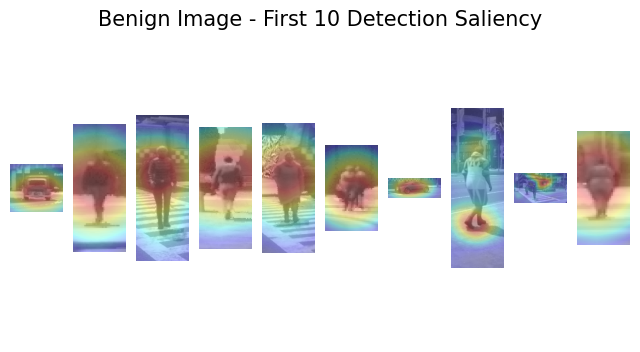

In [6]:
dets = list(detector([img_benign]))[0]
ref_idxs = list(range(0,10))
ref_dets = [list(dets)[idx] for idx in ref_idxs]
ref_bboxes, ref_scores = dets_to_mats(ref_dets)
sal_maps = run_detect_saliency(img_benign,ref_bboxes,ref_scores)
visualize_saliency_plot("Benign Image - First 10 Detection Saliency", img, sal_maps, ref_bboxes)

### Adversarial Patch Saliency <a name="Generate-Saliency-Adversarial-Patch-XAITK-Armory"></a>

Visualizing the first 10 detection saliency on the adversarial patch.

['person', 'vehicle', 'traffic light']
Saliency maps: (10, 960, 1280)


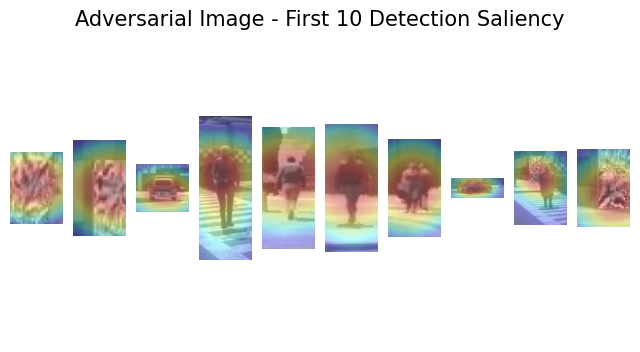

In [7]:
dets = list(detector([img]))[0]
ref_idxs = list(range(0,10))
ref_dets = [list(dets)[idx] for idx in ref_idxs]
ref_bboxes, ref_scores = dets_to_mats(ref_dets)
sal_maps = run_detect_saliency(img,ref_bboxes,ref_scores)
visualize_saliency_plot("Adversarial Image - First 10 Detection Saliency", img, sal_maps, ref_bboxes)